In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/raw/paysim.csv")

In [17]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### 1. Basic Info

In [12]:
df.shape

(6362620, 11)

In [13]:
print(df.info)

<bound method DataFrame.info of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1

In [14]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


We can see that there is no null values in the dataset.

#### Target Distribution

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


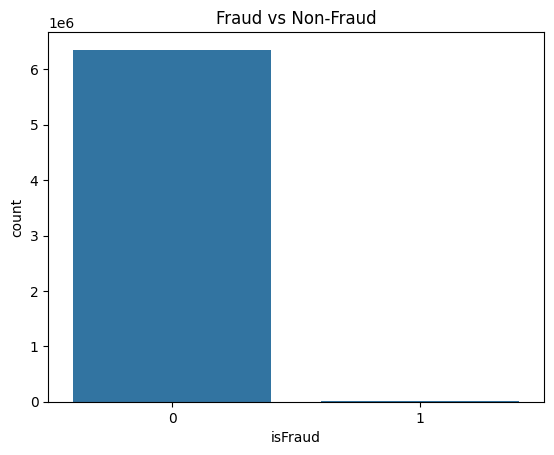

In [16]:
print(df["isFraud"].value_counts(normalize=True))
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()

The dataset is **extremely imbalanced**, with fraudulent transactions making up only ~0.13% of all transactions. This is expected in real-world fraud detection scenarios, where fraud is rare but very costly when it occurs.

### 2. Transaction Type

In [19]:
print(df['type'].value_counts())

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [21]:
fraud_counts = df[df['isFraud'] == 1]['type'].value_counts()
print("Fraudulent transactions by type:\n", fraud_counts)

Fraudulent transactions by type:
 type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


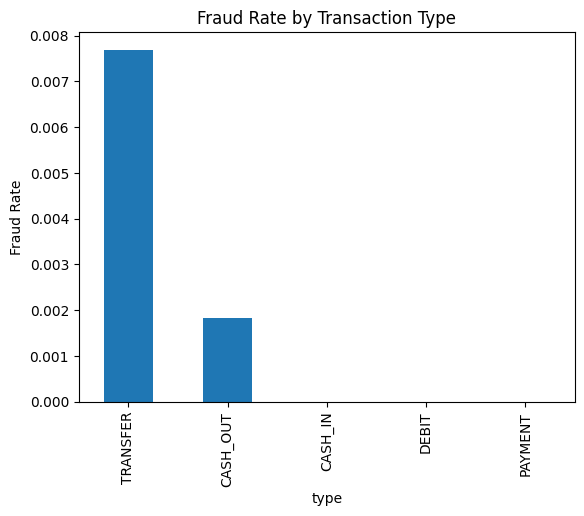

In [20]:
fraud_by_type =  df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', title='Fraud Rate by Transaction Type')
plt.ylabel("Fraud Rate")
plt.show()

Out of all transaction types, only TRANSFER and CASH_OUT contain fraudulent transactions. Other types like PAYMENT, CASH_IN, and DEBIT have zero fraud cases, indicating they are not exploited by fraudsters in this simulation.
This insight is critical and can be used to **filter the data before model training**, reducing noise and improving classifier performance.

### 3. Amount Analysis

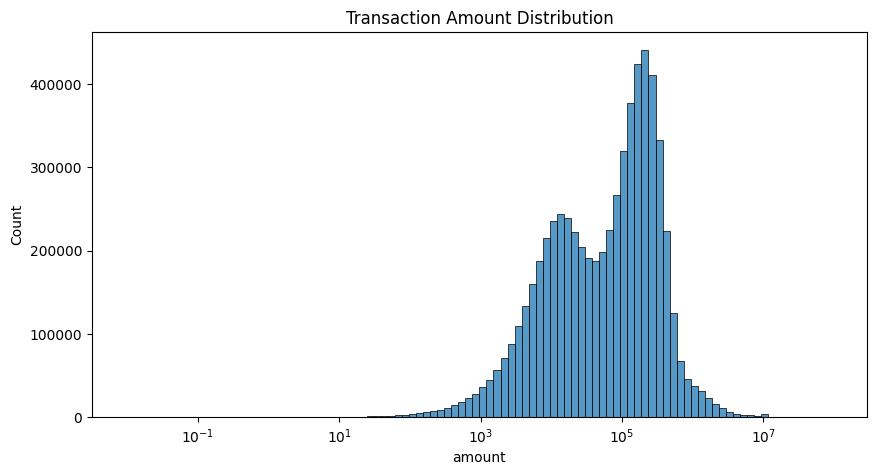

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(df['amount'], bins=100, log_scale=True)
plt.title("Transaction Amount Distribution")
plt.show()

* The transaction amounts are heavily right-skewed (long tail) — typical for financial data.

* After log scaling:

    * Most transactions occur around **10,000 to 100,000** units.

    * There are **two peaks** (bimodal): possibly **low-value customer activity** and **high-value business/merchant transfers**.

    * Extreme values (up to 10 million+) are rare.





💡 **Insight**:
* Feature engineering (e.g., log(amount + 1)) may help reduce skew and improve model performance.

* Outliers are natural in fraud datasets — but may also signal **potential fraud**.

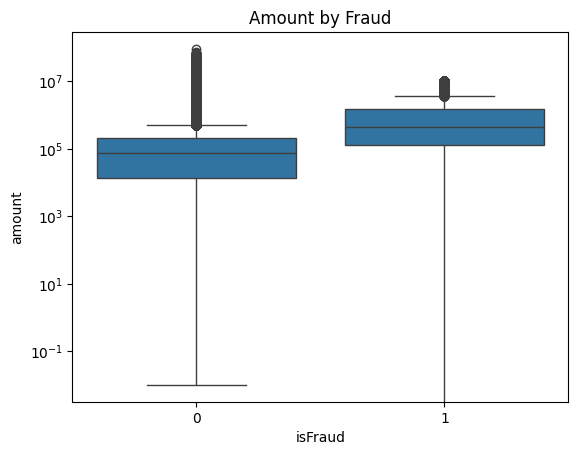

In [23]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title("Amount by Fraud")
plt.yscale('log')
plt.show()

* Fraudulent transactions (`isFraud == 1`) tend to involve **higher median amounts** than non-fraudulent ones.
* Even on a **log scale**, the **spread of fraud transactions is wider** and shifted upward.
* Non-fraud transactions have:
  * More small-value noise 
  *  A lower median 
  *  Long tail, but with a lower frequency of very large values

Fraudulent **transactions are more likely to involve larger amounts** compared to normal transactions.
This makes sense: fraudsters target high-value transactions for maximum profit in few attempts.

### 4. Balance Logic Checks


In [24]:
df['errorOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errorDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
print("Origin Balance Errors (sample):", df['errorOrig'].abs().describe())
print("Destination Balance Errors (sample):", df['errorDest'].abs().describe())

Origin Balance Errors (sample): count    6.362620e+06
mean     2.010925e+05
std      6.066505e+05
min      0.000000e+00
25%      2.954230e+03
50%      6.867726e+04
75%      2.496411e+05
max      9.244552e+07
Name: errorOrig, dtype: float64
Destination Balance Errors (sample): count    6.362620e+06
mean     9.359907e+04
std      4.350570e+05
min      0.000000e+00
25%      0.000000e+00
50%      5.123620e+03
75%      4.342133e+04
max      7.588573e+07
Name: errorDest, dtype: float64


* **Anomalies exist in the balance updates** — potentially due to:
  * **Missing or inconsistent data** (e.g., some accounts have 0 balance or null update)
  * **Simulation artifacts** (common in synthetic datasets)
  * **Fraudulent manipulation** (e.g., balance doesn’t change correctly)
* A large `errorOrig` or `errorDest` could be a **useful feature for fraud detection**:
  > If a transaction violates expected balance behavior, it might be suspicious.”



In [25]:
df['abs_errorOrig'] = df['errorOrig'].abs()
df['abs_errorDest'] = df['errorDest'].abs()


### 5. isFlaggedFraud

In [29]:
print(df['isFlaggedFraud'].value_counts())
flagged_fraud = df[df['isFlaggedFraud'] == 1]
print("Flagged Fraud - Actual fraud count:", flagged_fraud['isFraud'].sum())
print("Total number of frauds:", df['isFraud'].sum())


isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64
Flagged Fraud - Actual fraud count: 16
Total number of frauds: 8213


* ⚠️ **Only 16 out of ~6.3 million transactions** were flagged — that’s just **0.00025%**!
* ✅ **All 16 flagged were indeed frauds** — **precision = 100%**.
* ❌ But **recall is terrible** — total frauds in the dataset are 8213, so recall = `16 / 8213 ≈ 0.19%`.



### 6. Temporal Trends

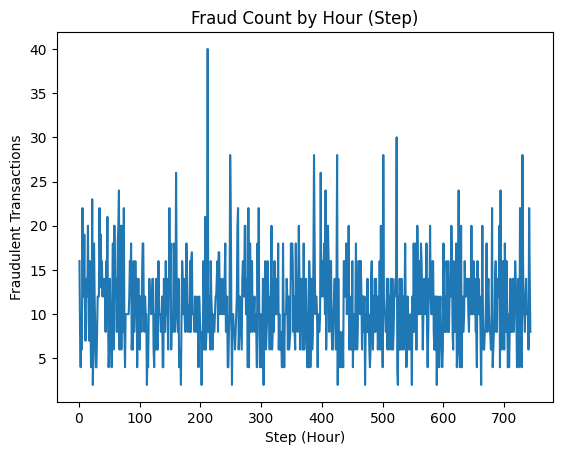

In [27]:
fraud_by_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(fraud_by_step)
plt.title("Fraud Count by Hour (Step)")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraudulent Transactions")
plt.show()

* **Fraud is spread out fairly evenly over time.**
* There are **some hourly spikes**, but no strong temporal correlation.
* For building a model, `step` **may not be a very predictive feature** on its own — unless:
    * You extract **time-of-day** or **rolling window** patterns
    * Or combine it with `transaction type` or `amount`

#### Heatmap: Fraud count by type & time


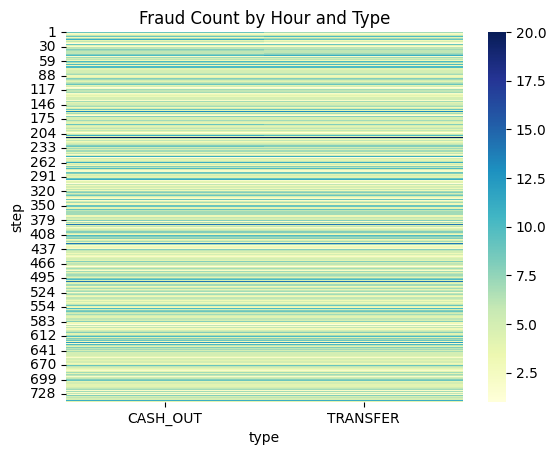

In [28]:

heatmap_data = df[df['isFraud'] == 1].pivot_table(index='step', columns='type', values='isFraud', aggfunc='count')
sns.heatmap(heatmap_data.fillna(0), cmap="YlGnBu")
plt.title("Fraud Count by Hour and Type")
plt.show()

Fraudulent transactions are not concentrated in any specific time window - they are **distributed fairly evenly** across the 744-hour simulation period. This suggests a **uniform fraud generation mechanism** in the synthetic dataset (i.e., no temporal bias or simulation of smart fraud behavior).



### 7. Correlation Matrix

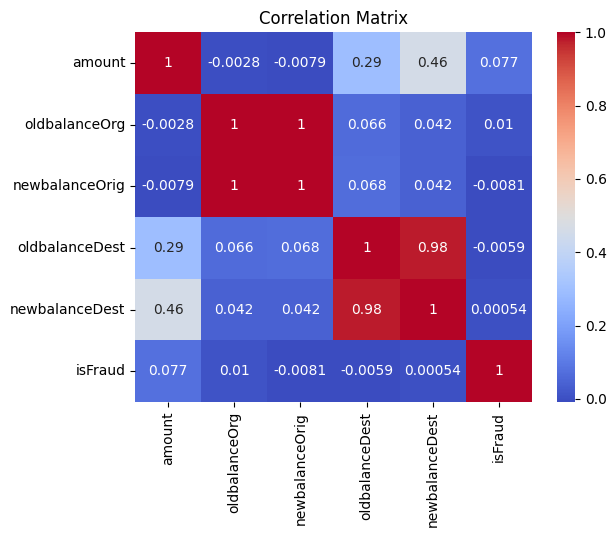

In [30]:
corr_matrix = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                  'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The data has high multicollinearity between origin and destination balances (e.g., oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest). But none of the raw features strongly correlate with fraud — reinforcing the need for **feature engineering and nonlinear models** like Random Forest, XGBoost, or Neural Net